<a href="https://colab.research.google.com/github/acruzvela/mnist_tensorflow/blob/main/PRACTICA_MNIST_Redes_Convolucionales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PRACTICA_Clasificación del conjunto MNIST con Redes Convolucionales

Vamos a realizar la clasificación del conjunto MNIST (que ya realizamos en los tutoriales anteriores con una red neuronal densa) mediante el entrenamiento de una red neuronal convolucional para tratar de resolver este problema de **clasificación multiclase**.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [2]:
!nvidia-smi

Fri Oct 31 16:58:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Obtenemos y visualizamos el dataset

Obtenemos el dataset del conjunto de imágenes MINIST desde Keras.

Se trata de un conjunto de imágenes de números escritos a mano del 0 al 9 dividido en dos subconjuntos:
- Subconjunto de entrenamiento: formado por 60.000 imágenes de 28x28 píxeles.
- Subconjunto de test: formado por 10.000 imágenes de 28x28 píxeles.

Todas las imágenes son en blanco y negro, con valores en cada pixel entre 0 y 255.

Hay 10 clases en las imágenes correspondientes a los números del 0 al 9.

Las distribución de las clases está equilibrada en los subconjuntos de entrenamiento, con unas 6000 muestras por clase, y de test, con unas 1000 muestras por clase.

In [3]:
# descargamos el dataset MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# obtenemos las dimensiones de las imágenes del subconjunto de entrenamiento
print(X_train.shape)

(60000, 28, 28)


In [5]:
# obtenemos las dimensiones de las etiquetas del subconjunto de entrenamiento
print(y_train.shape)

(60000,)


In [6]:
# obtenemos las dimensiones de las imágenes del subconjunto de test
print(X_test.shape)

(10000, 28, 28)


In [7]:
# obtenemos las dimensiones de las etiquetas del subconjunto de test
print(y_test.shape)

(10000,)


In [8]:
# dimensiones de una imagen individual
X_train[0].shape

(28, 28)

In [9]:
print('Valor máximo del pixel:', np.max(X_train[0]))
print('Valor mínimo del pixel:', np.min(X_train[0]))

Valor máximo del pixel: 255
Valor mínimo del pixel: 0


In [10]:
# obtenemos los valores únicos del numpy array
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


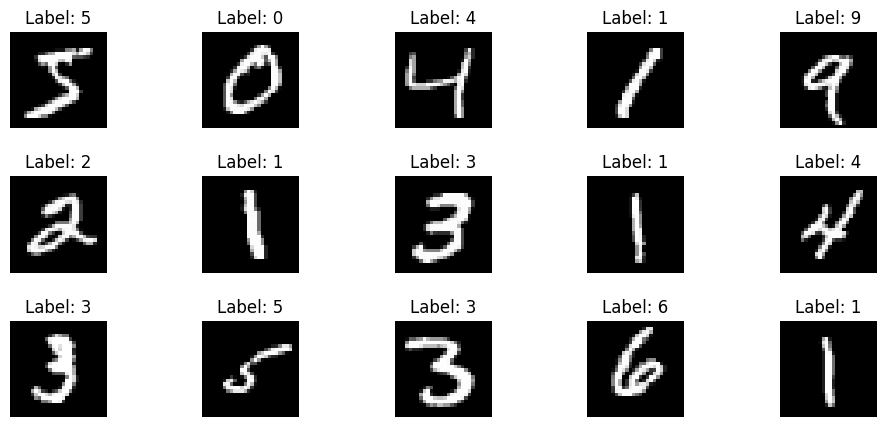

In [11]:
# creamos una figura con 2 filas y 5 columnas de imágenes
fig, axes = plt.subplots(3, 5, figsize=(12, 5))
axes = axes.ravel()

# iteramos sobre 15 imágenes
for i in np.arange(0, 15):
    axes[i].imshow(X_train[i], cmap='gray')
    axes[i].set_title(f"Label: {y_train[i]}", fontsize=12)
    plt.subplots_adjust(hspace=0.5)
    axes[i].axis('off')

plt.show()

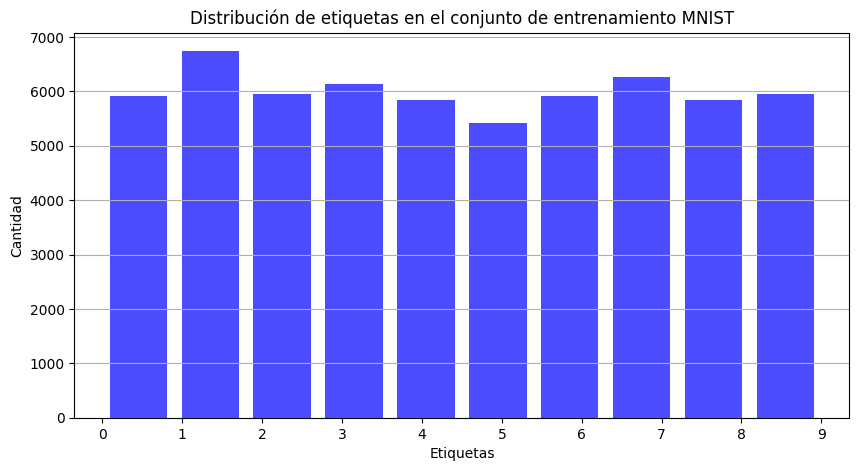

In [12]:
# vemos la distribución de imágenes para cada número en el conjunto de datos de entrenamiento
plt.figure(figsize=(10, 5))
plt.hist(y_train, bins=10, rwidth=0.8, color='blue', alpha=0.7)
plt.title('Distribución de etiquetas en el conjunto de entrenamiento MNIST')
plt.xlabel('Etiquetas')
plt.ylabel('Cantidad')
plt.xticks(np.arange(0, 10))
plt.grid(axis='y')
plt.show()

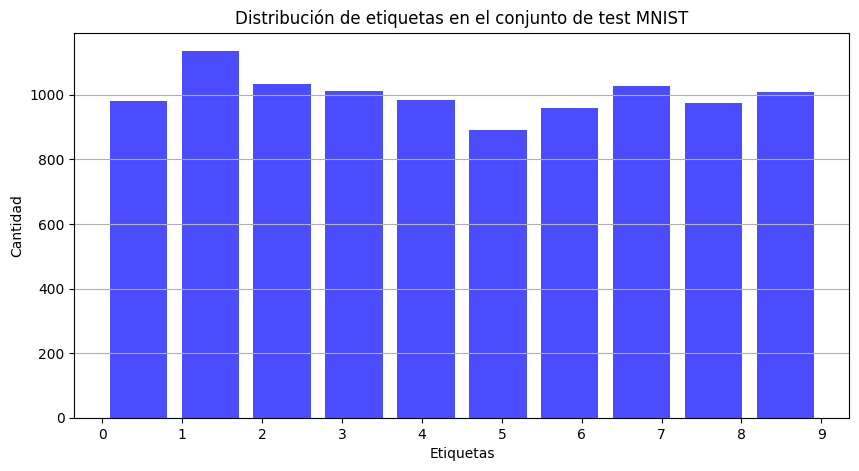

In [13]:
# vemos la distribución de imágenes para cada número en el conjunto de datos de test
plt.figure(figsize=(10, 5))
plt.hist(y_test, bins=10, rwidth=0.8, color='blue', alpha=0.7)
plt.title('Distribución de etiquetas en el conjunto de test MNIST')
plt.xlabel('Etiquetas')
plt.ylabel('Cantidad')
plt.xticks(np.arange(0, 10))
plt.grid(axis='y')
plt.show()

### Transformamos los datos

Vamos a realizar las siguientes transformaciones en las imágenes, previamente a pasarlas por la red neuronal convolucional:
- Modificamos las dimensiones de las imágenes para que sean de (28,28,1), es decir, imágenes de 28x28 pixeles con 1 canal (imágenes en blanco y negro).
- Convertimos los numeros enteros de los píxeles a numeros reales.
- Normalizamos las imágenes, de manera que los valores de cada pixel pasa de estar entre 0 y 255 a estar entre 0 y 1. Para ello, dividimos los valores de la intensidad de cada pixel entre 255. Esta transnformación le va a dar estabilidad al entrenamiento de la red.

Además, vamos a comprobar las dimensiones resultantes de los datasets.

In [14]:
# modificamos las imágenes del subconjunto de entrenamiento
X_train_model = X_train.reshape(-1, 28, 28, 1).astype('float32')/255.0

# modificamos las imágenes del subconjunto de test
X_test_model = X_test.reshape(-1, 28, 28, 1).astype('float32')/255.0

print('Dimensiones de las imágenes del subconjunto de entrenamiento: ', X_train_model.shape)
print('Dimensiones de las imágenes del subconjunto de test: ', X_test_model.shape)

Dimensiones de las imágenes del subconjunto de entrenamiento:  (60000, 28, 28, 1)
Dimensiones de las imágenes del subconjunto de test:  (10000, 28, 28, 1)


### Definimos la red neuronal

Para la red neuronal convolucional vamos a definir dos capas convolucionales de 32 y 64 filtros, un kernel de 3x3 y activación ReLU, seguidas de MaxPooling. La primera capa convolucional recibe un tensor de dimensiones (28,28,1), correspondiente a la imagen en blanco y negro.

Después de estas dos convoluciones, vamos a realizar un dropout del 50% para la regularización y convertimos la salida a un tersor unidimensional, mediante el aplanamiento del tensor resultante.

Posteriormente vamos a aplicar una salida con una capa densa de 10 neuronas con función de activación softmax para clasificación multiclase.

Usaremos para la definición del modelo el modo Secuencial.

In [15]:
# definimos el modelo de red neuronal
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# definimos el optimizador Adam
optimizer_model = tf.keras.optimizers.Adam(learning_rate=0.0002)
# definimos la función de pérdida como Spase Categorical Crossentropy
# ya que las etiquetas de las clases nos vienen dadas como números enteros
loss_model = tf.keras.losses.SparseCategoricalCrossentropy()

# compilamos el modelo, usando como optimizador y la pçerdida definidas y como métrica la accuracy
model.compile(optimizer=optimizer_model, loss=loss_model, metrics=['accuracy'])

In [17]:
# entrenamos el modelo con los datos de entrenamiento, definiendo
# el 20% del dataset como  validacion
history = model.fit(x=X_train_model,
                    y=y_train,
                    batch_size=32,
                    epochs=25,
                    validation_split = 0.2)

Epoch 1/25
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7101 - loss: 0.9765 - val_accuracy: 0.9592 - val_loss: 0.1472
Epoch 2/25
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9430 - loss: 0.1904 - val_accuracy: 0.9697 - val_loss: 0.1053
Epoch 3/25
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9582 - loss: 0.1349 - val_accuracy: 0.9771 - val_loss: 0.0820
Epoch 4/25
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9665 - loss: 0.1100 - val_accuracy: 0.9805 - val_loss: 0.0723
Epoch 5/25
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9708 - loss: 0.0948 - val_accuracy: 0.9824 - val_loss: 0.0628
Epoch 6/25
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9770 - loss: 0.0762 - val_accuracy: 0.9850 - val_loss: 0.0549
Epoch 7/25
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9765 - loss: 0.0749 - val_accuracy: 0.9843 - val_loss: 0.0560
Epoch 8/25
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9793 - loss: 0.0656 -

In [18]:
# obtenemos la información del entrenamiento y la validación
training_accuracy = history.history['accuracy']
training_loss = history.history['loss']
validation_accuracy = history.history['val_accuracy']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_accuracy) + 1)

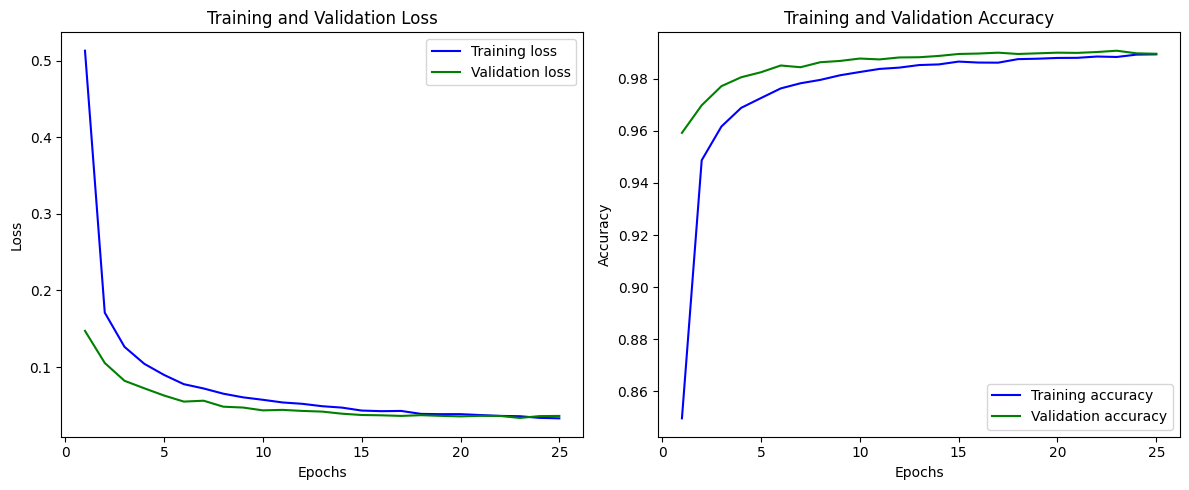

In [19]:
# dibujamos la evolución de la accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training loss', color='blue')
plt.plot(epochs, validation_loss, label='Validation loss', color='green')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# dibujamos la evolución de la accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training accuracy', color='blue')
plt.plot(epochs, validation_accuracy, label='Validation accuracy', color='green')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Inferencia

Con el modelo entrenado, vamos a hacer inferencia sobre algunas imágenes del subconjunto de test y visualizar si la imagen y la etiqueta se corresponde con la predicción.

In [20]:
# cogemos las primeras 10 imágenes del subconjunto de test
sample_images = X_test_model[:10]

In [21]:
# realizamos las predicciones con el modelo entrenado
predicted_probs = model.predict(sample_images)
predicted_labels = np.argmax(predicted_probs, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


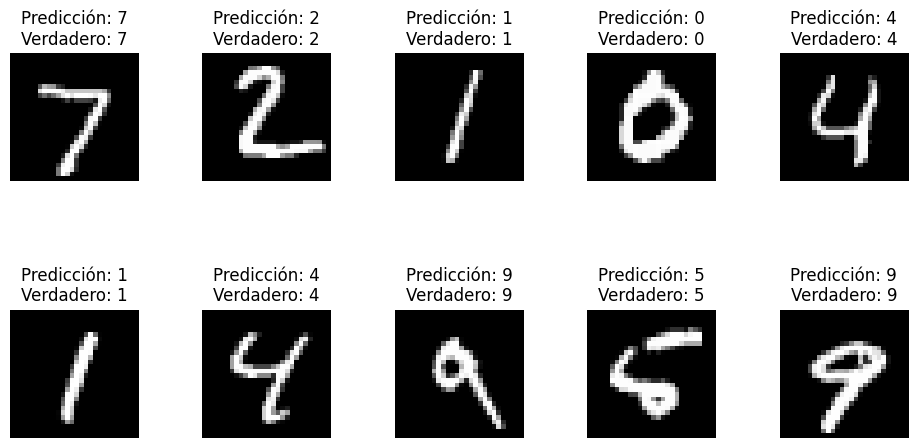

In [22]:
# creamos una figura con 2 filas y 5 columnas
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

# iteramos sobre las 10 imágenes
for i in np.arange(0, 10):
    axes[i].imshow(X_test[i], cmap='gray')
    axes[i].set_title(f"Predicción: {predicted_labels[i]}\nVerdadero: {y_test[i]}", fontsize=12)
    plt.subplots_adjust(hspace=1)
    axes[i].axis('off')

plt.show()